In [66]:
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px 
import numpy as np 
from colorama import Fore, Back, Style
from scipy.stats import chi2_contingency, f_oneway, ttest_ind

%matplotlib inline
pd.set_option('display.float_format', lambda x:'%.3f' % x)
np.printoptions(suppress=True, precision=3)

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, accuracy_score
import optuna

import shap

### Carregando dados

In [67]:
df_clientes = pd.read_csv(r'datasets\dataset_clientes.csv')


In [68]:
# Estrutura do Data set de clientes atuais
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   object 
 1   Nome                         1000 non-null   object 
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   object 
 13  Cargo              

In [69]:
# 10 primeiros registos do data frame de clientes
df_clientes.head(10)

,ID_Cliente,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,...,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão
0,bc3749c2-932f-462b-a71e-d1a352510f67,Nicole Lopes,32,5,4,2,4,5,3,1,...,2,Próprio,True,34118,631262,55649,294254,0.000,232,Rocketseat Mastercard Travel Elite
1,981dffc4-087e-4a99-bbac-062944f9b5a7,Kevin Teixeira,42,1,4,5,1,4,1,5,...,2,Alugado,True,7338,376417,1777324,180331,87.000,27,Rocketseat Mastercard Life Basic
2,242f4e94-7f2a-4557-a27a-9227cca55e83,Augusto Sá,67,4,3,4,3,2,3,3,...,6,Alugado,True,19965,83667,1793731,122049,78.450,57,Rocketseat Mastercard Travel Basic
3,e6f16b89-d9bf-4448-9d08-65957cdc1fb3,Ágatha Moura,47,2,3,1,2,1,3,4,...,6,Próprio,False,25867,283060,1940685,335544,85.210,32,Rocketseat Visa Travel Basic
4,79b7f5b0-e754-4cd9-9150-ed5913fef23a,João Rios,27,3,5,4,5,4,3,2,...,1,Alugado,True,18359,146413,517215,390588,89.120,0,Rocketseat Visa Life Basic
5,c403b04d-6f51-4374-b367-1adce70cdafb,Juliana Sales,56,5,3,5,1,1,5,3,...,4,Alugado,False,5163,403457,800313,312417,82.440,0,Rocketseat Mastercard Travel Basic
6,fd42f59f-18f3-428a-8e04-83263518946a,Sra. Brenda Almeida,50,5,5,2,2,3,2,5,...,1,Alugado,False,7973,912804,1311349,156471,78.360,74,Rocketseat Visa Travel Basic
7,e1a94ba9-8c52-4bc0-a7c5-6ea6ab430f6e,Lavínia Rios,33,1,4,1,5,2,2,4,...,5,Alugado,False,4796,252572,1841319,297458,93.470,4,Rocketseat Visa Life Basic
8,bb3e64ba-c46b-4ce7-a915-a5ac5d25fb3e,Rhavi Rezende,60,1,2,2,1,3,1,5,...,1,Alugado,True,43590,391559,918762,471656,76.120,43,Rocketseat Mastercard Travel Basic
9,11278877-2221-4c1c-842a-d8fe968f295e,Otto Correia,75,3,4,2,5,2,5,5,...,2,Alugado,True,3058,901393,692958,37149,59.740,135,Rocketseat Visa Life Select


In [70]:
df_clientes.isna().sum()

ID_Cliente                     0
Nome                           0
Idade                          0
Viagens                        0
Restaurantes                   0
Entretenimento                 0
Cashback                       0
Compras online                 0
Farmácias                      0
Programas de Milhagem          0
Postos de Combustível          0
Mercados                       0
Cidade                         0
Cargo                          0
Estado Civil                   0
Tempo na Empresa               0
Pessoas em Casa                0
Moradia                        0
Possui Carro                   0
Renda                          0
Investimentos                  0
Ativos                         0
Dívidas                        0
Probabilidade Inadimplencia    0
Score                          0
Principal Cartão               0
dtype: int64

Dataset de clientes não possui entradas nulas

### Engenharia de Features

In [71]:
# Removendo colunas de linhas unicas para cada entrada, e a variavel target Score
df_clientes.drop(columns=['ID_Cliente', 'Nome'], axis=1, inplace=True)

In [72]:
df_clientes['Possui Carro'] = df_clientes['Possui Carro'].astype(int)

In [73]:
df_clientes[['Rocketseat', 
            'Bandeira_Cartão',
            'Utilidade_Cartão', 
            'Categoria_Cartão']] = df_clientes['Principal Cartão'].str.split(' ', expand=True)

In [74]:
df_clientes.head(10)

,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,...,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão,Rocketseat,Bandeira_Cartão,Utilidade_Cartão,Categoria_Cartão
0,32,5,4,2,4,5,3,1,2,4,...,631262,55649,294254,0.000,232,Rocketseat Mastercard Travel Elite,Rocketseat,Mastercard,Travel,Elite
1,42,1,4,5,1,4,1,5,3,5,...,376417,1777324,180331,87.000,27,Rocketseat Mastercard Life Basic,Rocketseat,Mastercard,Life,Basic
2,67,4,3,4,3,2,3,3,2,3,...,83667,1793731,122049,78.450,57,Rocketseat Mastercard Travel Basic,Rocketseat,Mastercard,Travel,Basic
3,47,2,3,1,2,1,3,4,3,1,...,283060,1940685,335544,85.210,32,Rocketseat Visa Travel Basic,Rocketseat,Visa,Travel,Basic
4,27,3,5,4,5,4,3,2,2,5,...,146413,517215,390588,89.120,0,Rocketseat Visa Life Basic,Rocketseat,Visa,Life,Basic
5,56,5,3,5,1,1,5,3,3,1,...,403457,800313,312417,82.440,0,Rocketseat Mastercard Travel Basic,Rocketseat,Mastercard,Travel,Basic
6,50,5,5,2,2,3,2,5,5,1,...,912804,1311349,156471,78.360,74,Rocketseat Visa Travel Basic,Rocketseat,Visa,Travel,Basic
7,33,1,4,1,5,2,2,4,5,2,...,252572,1841319,297458,93.470,4,Rocketseat Visa Life Basic,Rocketseat,Visa,Life,Basic
8,60,1,2,2,1,3,1,5,5,2,...,391559,918762,471656,76.120,43,Rocketseat Mastercard Travel Basic,Rocketseat,Mastercard,Travel,Basic
9,75,3,4,2,5,2,5,5,4,2,...,901393,692958,37149,59.740,135,Rocketseat Visa Life Select,Rocketseat,Visa,Life,Select


In [75]:
# Verificar se há features categoricas de valores unicos

categorical_features = df_clientes.select_dtypes(include=['object']).columns

for col in categorical_features:
    print(f"Coluna: {col} possui os possiveis valores:\n{df_clientes[col].unique()}\n")

Coluna: Cidade possui os possiveis valores:
['Brasília' 'Campo Grande' 'Goiânia' 'Porto Alegre' 'Fortaleza' 'Curitiba'
 'Manaus' 'Florianópolis' 'Rio de Janeiro' 'São Paulo' 'Belém'
 'Belo Horizonte' 'Recife' 'Vitória' 'Salvador']

Coluna: Cargo possui os possiveis valores:
['Engenheiro agrônomo' 'Psicólogo' 'Intérprete de Bíblias'
 'Engenheiro de projetos' 'Cantor' 'Tecelão' 'Babysitter' 'Astronauta'
 'Ferramenteiro' 'Garimpeiro' 'Contábil' 'Assessor de imprensa'
 'Lanterneiro' 'Intérprete e tradutor de língua de sinais' 'Meeiro'
 'Lavador' 'Cancerologista ou Oncologista' 'Ambientalista' 'Almoxarife'
 'Jogador de basquete' 'Barman' 'Escoteiro' 'Gerente de riscos em seguros'
 'Parteira tradicional' 'Produtor de multimídia' 'Restaurador'
 'Office-boy' 'Estampador de tecidos' 'Biomédico' 'Geógrafo' 'Coronel'
 'Químico' 'Servente-de-obras' 'Gestor ambiental'
 'Tecnólogo em geoprocessamento' 'Instalador de linha telefônica'
 'Viveirista' 'Toxicologista' 'Pescador' 'Coloproctologista'
 'Méd

In [76]:
# Verificar se há features numericas de valores unicos

numeric_features = df_clientes.select_dtypes(include=['number']).columns

for col in numeric_features:
    print(f"Coluna: {col} possui os possiveis valores:\n{df_clientes[col].unique()}\n")

Coluna: Idade possui os possiveis valores:
[32 42 67 47 27 56 50 33 60 75 40 73 21 74 53 68 43 46 57 44 35 29 78 54
 70 69 23 64 18 76 48 80 71 59 66 24 72 22 41 79 19 31 38 58 39 20 77 25
 65 63 62 37 28 36 61 30 49 45 52 34 51 55 26]

Coluna: Viagens possui os possiveis valores:
[5 1 4 2 3]

Coluna: Restaurantes possui os possiveis valores:
[4 3 5 2 1]

Coluna: Entretenimento possui os possiveis valores:
[2 5 4 1 3]

Coluna: Cashback possui os possiveis valores:
[4 1 3 2 5]

Coluna: Compras online possui os possiveis valores:
[5 4 2 1 3]

Coluna: Farmácias possui os possiveis valores:
[3 1 5 2 4]

Coluna: Programas de Milhagem possui os possiveis valores:
[1 5 3 4 2]

Coluna: Postos de Combustível possui os possiveis valores:
[2 3 5 4 1]

Coluna: Mercados possui os possiveis valores:
[4 5 3 1 2]

Coluna: Tempo na Empresa possui os possiveis valores:
[ 4 18 19  6  1  5 15  0 13 12 10 16  3 11  9  2  8 14  7 20 17]

Coluna: Pessoas em Casa possui os possiveis valores:
[2 6 1 4 5 3]

Co

A coluna Rocketseat possui apenas um valor, logo irei exclui-la, como dividi a coluna principal cartao em outras colunas tambem irei exclui-lá

In [77]:
df_clientes.drop(columns=['Rocketseat', 'Principal Cartão'],axis=1, inplace=True)

In [78]:
# Variavel Booleana para int
df_clientes['Possui Carro'] = (df_clientes['Possui Carro']).astype(int)

In [79]:
categorical_features = df_clientes.drop(columns=['Bandeira_Cartão', 'Utilidade_Cartão', 'Categoria_Cartão']).select_dtypes(include=['object']).columns
targets = ['Bandeira_Cartão','Utilidade_Cartão','Categoria_Cartão']
numeric_features = df_clientes.select_dtypes(include=['number']).columns

### EDA

In [80]:
# Estatisiticas das variaveis numericas

df_clientes.describe()

,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Tempo na Empresa,Pessoas em Casa,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,49.432,2.986,3.023,3.073,2.985,2.999,2.979,3.003,3.091,3.001,10.144,3.568,0.505,25556.416,485209.921,986604.889,248727.312,66.727,95.740
std,18.320,1.403,1.418,1.392,1.389,1.423,1.384,1.460,1.432,1.439,6.074,1.747,0.500,14468.363,289308.842,574234.666,143546.398,22.381,104.345
min,18.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1000.000,89.000,2538.000,31.000,0.000,0.000
25%,34.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,5.000,2.000,0.000,12695.250,225495.500,511514.250,122040.000,60.748,24.000
50%,49.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,10.000,4.000,1.000,25494.500,478102.500,957918.500,251886.500,74.290,62.000
75%,66.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,15.000,5.000,1.000,38384.750,733778.750,1492880.750,376115.250,81.005,131.000
max,80.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,20.000,6.000,1.000,49996.000,997209.000,1998481.000,499732.000,98.210,650.000


In [81]:
df_eda = df_clientes.copy()

In [82]:
df_eda['Moradia'] = (df_eda['Moradia'] == 'Próprio').astype(int)

In [83]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Idade                        1000 non-null   int64  
 1   Viagens                      1000 non-null   int64  
 2   Restaurantes                 1000 non-null   int64  
 3   Entretenimento               1000 non-null   int64  
 4   Cashback                     1000 non-null   int64  
 5   Compras online               1000 non-null   int64  
 6   Farmácias                    1000 non-null   int64  
 7   Programas de Milhagem        1000 non-null   int64  
 8   Postos de Combustível        1000 non-null   int64  
 9   Mercados                     1000 non-null   int64  
 10  Cidade                       1000 non-null   object 
 11  Cargo                        1000 non-null   object 
 12  Estado Civil                 1000 non-null   object 
 13  Tempo na Empresa   

#### Distribuições das variáveis numericas

In [84]:
for col in df_eda.select_dtypes(include=['number']).columns:
    fig = px.histogram(df_eda, x=col, nbins=20, title=f'Distribuição da variável {col}')
    fig.show()

In [85]:
for col in df_eda.select_dtypes(include=['object']).columns:
    df_count = df_eda[col].value_counts().reset_index()
    df_count.columns = ['Categoria', 'Contagem']
    fig = px.bar(df_count,
                 x='Contagem',
                 y='Categoria',
                 orientation='h',
                 title=f'Contagem por {col}')
    fig.show()

In [86]:
for target in targets:
    for col in df_eda.drop(columns=['Bandeira_Cartão','Utilidade_Cartão','Categoria_Cartão'],axis=1).select_dtypes(include=['number']).columns:
        fig = px.box(df_eda, x=target, y=col, title=f'{col} por {target}')
        fig.show()
    
    for col in df_eda.drop(columns=['Bandeira_Cartão','Utilidade_Cartão','Categoria_Cartão'],axis=1).select_dtypes(include=['object']).columns:
        fig = px.histogram(df_eda, x=col,color=target, barmode='group', title=f'{col} por {target}')
        fig.show()


Variável Viagens:
- Pessoas que viajam com mais frequência possuem como utilidade do cartão travel, pessoas que possuem uma frequência intermediaria de viagem possuem uma utilidade life no cartão, e pessoas que não costumam viajar tem a utilidade shopping.

Variável Restaurantes:
- Pessoas que vao a restaurantes com mais frequência possuem como utilidade do cartão life, pessoas que possuem uma frequência intermediaria de ida a restaurantes possuem uma utilidade travel/shopping.

Variável Entretenimento:
- Pessoas que vao a eventos de entretedimento com mais frequência possuem como utilidade do cartão life, pessoas que possuem uma frequência intermediaria de ida a eventos de entretenimento possuem uma utilidade travel no cartão, e pessoas que não costumam ir a eventos de entretenimento tem a utilidade shopping.

Variável Cashback:
- Pessoas que usam cashbacks com mais frequência possuem como utilidade do cartão travel/life e pessoas que não costumam usar cashbacks tem a utilidade shopping.

Variável Programas de Milhagem:
- Pessoas que usam programs de milhagem com mais frequência possuem como utilidade do cartão travel e pessoas que não costumam ou de maneira intermediaria usar programass de milhagem tem a utilidade shopping/life.

Variável Pessoas em Casa: 
- Clientes com 4 pessoas em casa possuem a utilidade travel ou life, enquanto pessoas com 3 pessoas tendem a ter a utilidade shopping

Variável Moradia:
- Pessoas com cartões de bandeira Master sua mediana aponta para que não possuam casa própria, enquanto a de bandeira visa aponta para que possuam casa própria
- Pessoas com moradia própria tendem a ter utilidade travel/ shopping e quem não tem casa própria tende a ter a utilidade life

Variável Possui Carro:
- Pessoas com cartões de bandeira Visa sua mediana aponta para que não possuam carro própria, enquanto a de bandeira Master aponta para que possuam casa própria

Variável Renda:
- A uma pequena diferença de quanto maior a renda mas a pessoa tende a ter cartão de utilidade de life / shopping
- quanto maior a renda maior a categoria

Variável Investimentos:
- quanto mais investimentos maior a categoria

Variável Dividas:
- quanto maior a divida menor a categoria do cartoa

Variável Probabilidade Inadimplencia: 
- quanto maior a prob menor a categoria do cartao

Variável Score:
- quanto maior o score melhor a categoria

Variável Cidade:
- Algumas cidades possuem uma diferença considerável na mediana de bandeiras do cartão
- A algumas cidades com diferenças expressivas na utilidade dos cartoes

Variável Cargo: 
- Alguns cargos possuem apenas um único tipo de badeira
- alguns cargos possuem apenas um único tipo de utilidade

In [87]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Idade                        1000 non-null   int64  
 1   Viagens                      1000 non-null   int64  
 2   Restaurantes                 1000 non-null   int64  
 3   Entretenimento               1000 non-null   int64  
 4   Cashback                     1000 non-null   int64  
 5   Compras online               1000 non-null   int64  
 6   Farmácias                    1000 non-null   int64  
 7   Programas de Milhagem        1000 non-null   int64  
 8   Postos de Combustível        1000 non-null   int64  
 9   Mercados                     1000 non-null   int64  
 10  Cidade                       1000 non-null   object 
 11  Cargo                        1000 non-null   object 
 12  Estado Civil                 1000 non-null   object 
 13  Tempo na Empresa   

#### Matriz de Correleção

In [88]:
df_corr = pd.get_dummies(
    df_eda.drop(columns=['Cargo', 'Cidade', 'Estado Civil'],axis=1),
    columns=['Bandeira_Cartão', 'Utilidade_Cartão', 'Categoria_Cartão'],
    drop_first=False
)

In [89]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Idade                        1000 non-null   int64  
 1   Viagens                      1000 non-null   int64  
 2   Restaurantes                 1000 non-null   int64  
 3   Entretenimento               1000 non-null   int64  
 4   Cashback                     1000 non-null   int64  
 5   Compras online               1000 non-null   int64  
 6   Farmácias                    1000 non-null   int64  
 7   Programas de Milhagem        1000 non-null   int64  
 8   Postos de Combustível        1000 non-null   int64  
 9   Mercados                     1000 non-null   int64  
 10  Tempo na Empresa             1000 non-null   int64  
 11  Pessoas em Casa              1000 non-null   int64  
 12  Moradia                      1000 non-null   int64  
 13  Possui Carro       

In [90]:
df_corr['Bandeira_Cartão_Mastercard'] = df_corr['Bandeira_Cartão_Mastercard'].astype(int)
df_corr['Bandeira_Cartão_Visa'] = df_corr['Bandeira_Cartão_Visa'].astype(int)
df_corr['Utilidade_Cartão_Life'] = df_corr['Utilidade_Cartão_Life'].astype(int)
df_corr['Utilidade_Cartão_Shopping'] = df_corr['Utilidade_Cartão_Shopping'].astype(int)
df_corr['Utilidade_Cartão_Travel'] = df_corr['Utilidade_Cartão_Travel'].astype(int)
df_corr['Categoria_Cartão_Basic'] = df_corr['Categoria_Cartão_Basic'].astype(int)
df_corr['Categoria_Cartão_Elite'] = df_corr['Categoria_Cartão_Elite'].astype(int)
df_corr['Categoria_Cartão_Platinum'] = df_corr['Categoria_Cartão_Platinum'].astype(int)
df_corr['Categoria_Cartão_Select'] = df_corr['Categoria_Cartão_Select'].astype(int)

In [91]:
correlation_matrix = df_corr.select_dtypes(include=['number']).corr()

fig = px.imshow(correlation_matrix, 
                color_continuous_scale='Viridis',
                title='Matriz de Correlação',
                zmin=-1,
                zmax=1)

fig.update_traces(text=correlation_matrix,
                  texttemplate='%{text:.1%}',
                  textfont=dict(size=9))

fig.update_layout(width=1200,
                  height= 1000,
                  title_font=dict(size=14),
                  font=dict(size=10)
                  )

fig.show()

#### Teste de Hipotese

In [92]:
for col in numeric_features:
    for target in targets:
        groups = [df_clientes[df_clientes[target] == val][col] for val in df_clientes[target].unique()]
        if df_clientes[target].nunique() <=2:
            stat, pvalue = ttest_ind(*groups)
            teste = 'T-Test'
        elif df_clientes[target].nunique() >2:
            stat, pvalue = f_oneway(*groups)
            teste = 'ANOVA'
        print(f'{Fore.RED if pvalue < 0.05 else Fore.WHITE}'
                f'{teste} entre {col} e {target}: p-valor = {pvalue}')

T-Test entre Idade e Bandeira_Cartão: p-valor = 0.20973715646775168
ANOVA entre Idade e Utilidade_Cartão: p-valor = 0.9836964413093396
ANOVA entre Idade e Categoria_Cartão: p-valor = 0.00021303474981769613
T-Test entre Viagens e Bandeira_Cartão: p-valor = 0.37472761823568
ANOVA entre Viagens e Utilidade_Cartão: p-valor = 7.027402768403964e-93
ANOVA entre Viagens e Categoria_Cartão: p-valor = 0.6747526258411571
T-Test entre Restaurantes e Bandeira_Cartão: p-valor = 0.0020196846394882045
ANOVA entre Restaurantes e Utilidade_Cartão: p-valor = 8.8360640004938e-18


ANOVA entre Restaurantes e Categoria_Cartão: p-valor = 0.33447839073430163
T-Test entre Entretenimento e Bandeira_Cartão: p-valor = 0.49021760449646123
ANOVA entre Entretenimento e Utilidade_Cartão: p-valor = 2.330178507329714e-25
ANOVA entre Entretenimento e Categoria_Cartão: p-valor = 0.5429659229516757
T-Test entre Cashback e Bandeira_Cartão: p-valor = 0.15561738770070063
ANOVA entre Cashback e Utilidade_Cartão: p-valor = 4.1488908002045255e-19
ANOVA entre Cashback e Categoria_Cartão: p-valor = 0.6223698204933683
T-Test entre Compras online e Bandeira_Cartão: p-valor = 0.10464070335684897
ANOVA entre Compras online e Utilidade_Cartão: p-valor = 0.0001322076511493731
ANOVA entre Compras online e Categoria_Cartão: p-valor = 0.5423241698028259
T-Test entre Farmácias e Bandeira_Cartão: p-valor = 0.02490451285058416
ANOVA entre Farmácias e Utilidade_Cartão: p-valor = 2.1619708900720735e-06
ANOVA entre Farmácias e Categoria_Cartão: p-valor = 0.6300682095528306
T-Test entre Programas de Mi

Variaveis Possui Carro, Pessoas em Casa e Tempo na Empresa são independentes dass variáveis targets, pois apresentaram p-value > 0.05 para ambas as targets

In [93]:
df_clientes.drop(columns=['Tempo na Empresa', 'Possui Carro', 'Pessoas em Casa'], axis=1, inplace=True)

In [96]:
# Teste de Qui-Quadrado para variáveis categoricas

for cat in categorical_features:
    for target in targets:
        contingecy_table = pd.crosstab(df_clientes[cat], df_clientes[target])
        chi2, p, dof, _ = chi2_contingency(contingecy_table)
        print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
            f"Teste de QUI-QUADRADO entre {cat} e {target}: p-valor = {p}")

Teste de QUI-QUADRADO entre Cidade e Bandeira_Cartão: p-valor = 0.4496521654668307
Teste de QUI-QUADRADO entre Cidade e Utilidade_Cartão: p-valor = 0.7868077773566184
Teste de QUI-QUADRADO entre Cidade e Categoria_Cartão: p-valor = 0.45667046933330524
Teste de QUI-QUADRADO entre Cargo e Bandeira_Cartão: p-valor = 0.4189928675242703
Teste de QUI-QUADRADO entre Cargo e Utilidade_Cartão: p-valor = 0.2637335462444067
Teste de QUI-QUADRADO entre Cargo e Categoria_Cartão: p-valor = 0.6360477342554689
Teste de QUI-QUADRADO entre Estado Civil e Bandeira_Cartão: p-valor = 0.7249423606019608
Teste de QUI-QUADRADO entre Estado Civil e Utilidade_Cartão: p-valor = 0.6183308124336524
Teste de QUI-QUADRADO entre Estado Civil e Categoria_Cartão: p-valor = 0.21510840116014351
Teste de QUI-QUADRADO entre Moradia e Bandeira_Cartão: p-valor = 0.2211614971706733
Teste de QUI-QUADRADO entre Moradia e Utilidade_Cartão: p-valor = 0.12248419216515778
Teste de QUI-QUADRADO entre Moradia e Categoria_Cartão: p-va

Todas as variáveis categoricas são independentes das targets

In [97]:
# Teste de Qui-Quadrado para variáveis categoricas

for cat in targets:
    for target in targets:
        contingecy_table = pd.crosstab(df_clientes[cat], df_clientes[target])
        chi2, p, dof, _ = chi2_contingency(contingecy_table)
        print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
            f"Teste de QUI-QUADRADO entre {cat} e {target}: p-valor = {p}")

Teste de QUI-QUADRADO entre Bandeira_Cartão e Bandeira_Cartão: p-valor = 1.3325821189156615e-218
Teste de QUI-QUADRADO entre Bandeira_Cartão e Utilidade_Cartão: p-valor = 0.6941298465544672
Teste de QUI-QUADRADO entre Bandeira_Cartão e Categoria_Cartão: p-valor = 0.9045438813668495
Teste de QUI-QUADRADO entre Utilidade_Cartão e Bandeira_Cartão: p-valor = 0.6941298465544672
Teste de QUI-QUADRADO entre Utilidade_Cartão e Utilidade_Cartão: p-valor = 0.0
Teste de QUI-QUADRADO entre Utilidade_Cartão e Categoria_Cartão: p-valor = 0.8720147537317257
Teste de QUI-QUADRADO entre Categoria_Cartão e Bandeira_Cartão: p-valor = 0.9045438813668495
Teste de QUI-QUADRADO entre Categoria_Cartão e Utilidade_Cartão: p-valor = 0.8720147537317257
Teste de QUI-QUADRADO entre Categoria_Cartão e Categoria_Cartão: p-valor = 0.0


Variáveis targets são independentes entre si

In [ ]:
df_clientes.drop(columns=['Cidade','Cargo','Estado Civil', 'Moradia'], axis=1, inplace=True)

In [ ]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Idade                        1000 non-null   int64  
 1   Viagens                      1000 non-null   int64  
 2   Restaurantes                 1000 non-null   int64  
 3   Entretenimento               1000 non-null   int64  
 4   Cashback                     1000 non-null   int64  
 5   Compras online               1000 non-null   int64  
 6   Farmácias                    1000 non-null   int64  
 7   Programas de Milhagem        1000 non-null   int64  
 8   Postos de Combustível        1000 non-null   int64  
 9   Mercados                     1000 non-null   int64  
 10  Renda                        1000 non-null   int64  
 11  Investimentos                1000 non-null   int64  
 12  Ativos                       1000 non-null   int64  
 13  Dívidas            

### Preparação dos Dados

In [ ]:
X = df_clientes.drop(columns=targets, axis=1)
y = df_clientes[targets]

y_bandeira   = df_clientes["Bandeira_Cartão"]
y_utilidade  = df_clientes["Utilidade_Cartão"]
y_categoria  = df_clientes["Categoria_Cartão"]

# Divisão
X_train, X_test, y_train_b, y_test_b = train_test_split(X, y_bandeira, test_size=0.3, random_state=42)
_, _, y_train_u, y_test_u = train_test_split(X, y_utilidade, test_size=0.3, random_state=42)
_, _, y_train_c, y_test_c = train_test_split(X, y_categoria, test_size=0.3, random_state=42)

### Treinando Modelo

In [ ]:
def objective_catboost_multiclass(trial, X_train, X_test, y_train, y_test):

    params = {
        "iterations": trial.suggest_int("iterations", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 20),
        "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
        "loss_function": "MultiClass",
        "eval_metric": "Accuracy",
        "verbose": False
    }

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

    preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, preds)

    return accuracy


In [ ]:
study_categoria = optuna.create_study(direction="maximize")
study_categoria.optimize(lambda trial: 
                         objective_catboost_multiclass(trial, X_train, X_test, y_train_c, y_test_c),
                         n_trials=50)


[I 2025-11-16 21:40:27,163] A new study created in memory with name: no-name-b82709ec-0488-4d9d-8183-0e2896e5b15e
[I 2025-11-16 21:40:29,970] Trial 0 finished with value: 1.0 and parameters: {'iterations': 821, 'learning_rate': 0.2249940467891098, 'depth': 5, 'l2_leaf_reg': 19, 'random_strength': 4.358776979464071}. Best is trial 0 with value: 1.0.
[I 2025-11-16 21:40:34,754] Trial 1 finished with value: 1.0 and parameters: {'iterations': 763, 'learning_rate': 0.16770239205618803, 'depth': 6, 'l2_leaf_reg': 8, 'random_strength': 2.635826666455084}. Best is trial 0 with value: 1.0.
[I 2025-11-16 21:40:45,179] Trial 2 finished with value: 1.0 and parameters: {'iterations': 468, 'learning_rate': 0.29814425074376055, 'depth': 8, 'l2_leaf_reg': 18, 'random_strength': 1.1497879602858248}. Best is trial 0 with value: 1.0.
[I 2025-11-16 21:42:14,274] Trial 3 finished with value: 1.0 and parameters: {'iterations': 1184, 'learning_rate': 0.061057438301241176, 'depth': 10, 'l2_leaf_reg': 15, 'ran

In [ ]:
study_utilidade = optuna.create_study(direction="maximize")
study_utilidade.optimize(lambda trial: 
                         objective_catboost_multiclass(trial, X_train, X_test, y_train_u, y_test_u),
                         n_trials=50)


[I 2025-11-16 21:53:49,950] A new study created in memory with name: no-name-8065ab25-b286-4c51-a566-84fd9f778a67
[I 2025-11-16 21:55:02,884] Trial 0 finished with value: 0.99 and parameters: {'iterations': 1244, 'learning_rate': 0.24866328840095667, 'depth': 10, 'l2_leaf_reg': 17, 'random_strength': 4.004505600993719}. Best is trial 0 with value: 0.99.
[I 2025-11-16 21:55:25,252] Trial 1 finished with value: 0.9933333333333333 and parameters: {'iterations': 368, 'learning_rate': 0.2684911058585873, 'depth': 10, 'l2_leaf_reg': 20, 'random_strength': 1.5732520772797778}. Best is trial 1 with value: 0.9933333333333333.
[I 2025-11-16 21:55:28,581] Trial 2 finished with value: 0.99 and parameters: {'iterations': 1037, 'learning_rate': 0.10211442857999632, 'depth': 5, 'l2_leaf_reg': 2, 'random_strength': 2.70079777540177}. Best is trial 1 with value: 0.9933333333333333.
[I 2025-11-16 21:55:30,585] Trial 3 finished with value: 0.99 and parameters: {'iterations': 910, 'learning_rate': 0.09908

In [ ]:
study_bandeira = optuna.create_study(direction="maximize")
study_bandeira.optimize(lambda trial: 
                        objective_catboost_multiclass(trial, X_train, X_test, y_train_b, y_test_b),
                        n_trials=50)

[I 2025-11-16 22:18:10,049] A new study created in memory with name: no-name-7b8e8feb-d850-4b68-aa04-c4c8a93fb3de
[I 2025-11-16 22:18:22,130] Trial 0 finished with value: 0.55 and parameters: {'iterations': 1143, 'learning_rate': 0.17730771501581905, 'depth': 8, 'l2_leaf_reg': 10, 'random_strength': 2.8182548687524958}. Best is trial 0 with value: 0.55.
[I 2025-11-16 22:18:27,064] Trial 1 finished with value: 0.5266666666666666 and parameters: {'iterations': 799, 'learning_rate': 0.10712120273416993, 'depth': 7, 'l2_leaf_reg': 20, 'random_strength': 3.0791586469494234}. Best is trial 0 with value: 0.55.
[I 2025-11-16 22:18:30,767] Trial 2 finished with value: 0.52 and parameters: {'iterations': 575, 'learning_rate': 0.12500435456872003, 'depth': 7, 'l2_leaf_reg': 15, 'random_strength': 4.393299824872837}. Best is trial 0 with value: 0.55.
[I 2025-11-16 22:19:19,249] Trial 3 finished with value: 0.5466666666666666 and parameters: {'iterations': 1223, 'learning_rate': 0.20211994737409827

In [ ]:
# Treinando melhores modelos

final_model_bandeira = CatBoostClassifier(**study_bandeira.best_params)
final_model_bandeira.fit(X_train, y_train_b, verbose=False)

In [ ]:
final_model_categoria = CatBoostClassifier(**study_categoria.best_params)
final_model_categoria.fit(X_train, y_train_c, verbose=False)

In [101]:
final_model_utilidade = CatBoostClassifier(**study_utilidade.best_params)
final_model_utilidade.fit(X_train, y_train_u, verbose=False)

In [102]:
pred_bandeira = final_model_bandeira.predict(X_test)
pred_utilidade = final_model_utilidade.predict(X_test)
pred_categoria = final_model_categoria.predict(X_test)

In [103]:
# Relatorio de classificacao

print('Relatorio de Classificação')
print('Relatorio da BANDEIRA')
print(classification_report(y_test_b, pred_bandeira))
print('Relatorio da UTILIDADE')
print(classification_report(y_test_u, pred_utilidade))
print('Relatorio da CATEGORIA')
print(classification_report(y_test_c, pred_categoria))

Relatorio de Classificação
Relatorio da BANDEIRA
              precision    recall  f1-score   support

  Mastercard       0.50      0.61      0.55       145
        Visa       0.54      0.44      0.49       155

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300

Relatorio da UTILIDADE
              precision    recall  f1-score   support

        Life       0.99      1.00      1.00       134
    Shopping       1.00      1.00      1.00        90
      Travel       1.00      0.99      0.99        76

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Relatorio da CATEGORIA
              precision    recall  f1-score   support

       Basic       1.00      1.00      1.00       201
       Elite       1.00      1.00      1.00        33
    Platinum       1.00      1.00 

Visto que as features não explicam muito bem a target bandeira, o modelo não conseguiu predizelas corretamente, enquanto as features conseguem explicar muito bem as targets categoria e utilidade o modelo obteve excelentes metricas.

In [113]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_test_u)

print(le.classes_)

['Life' 'Shopping' 'Travel']



Matriz de Confusão para Bandeira


Text(0.5, 1.0, 'Matriz de Confusão para Bandeira')

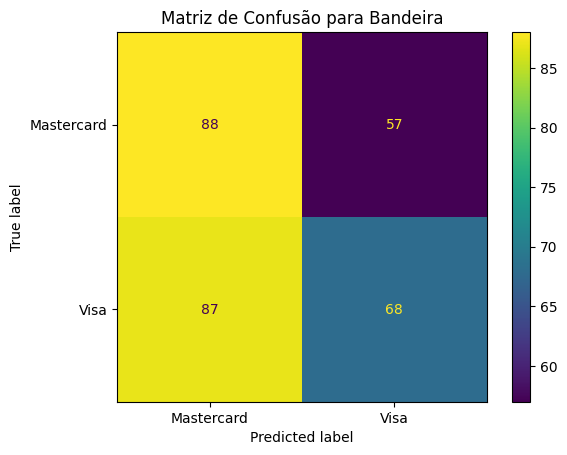

In [110]:
print(f'\nMatriz de Confusão para Bandeira')
conf_matrix = confusion_matrix(y_test_b, pred_bandeira)
fig = ConfusionMatrixDisplay(conf_matrix,
                                display_labels=['Mastercard','Visa'],
                                )
fig.plot()
plt.title(f'Matriz de Confusão para Bandeira')

Como visto anteriormente pela análise das metricas o modelo não consegue destinguir, com base nessas features, quando  bandeira do cartão é visa ou master 


Matriz de Confusão para Utilidade


Text(0.5, 1.0, 'Matriz de Confusão para Utilidade')

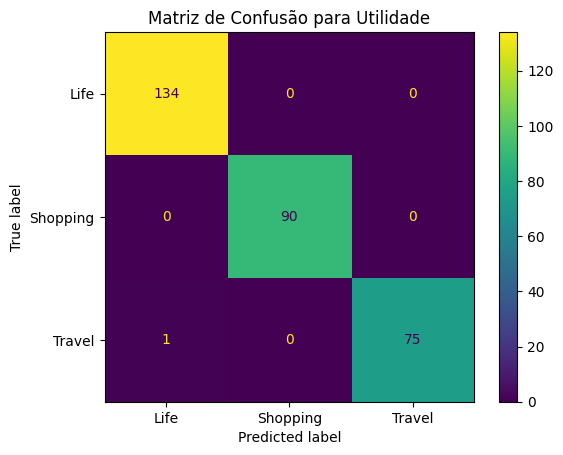

In [114]:
print(f'\nMatriz de Confusão para Utilidade')
conf_matrix = confusion_matrix(y_test_u, pred_utilidade)
fig = ConfusionMatrixDisplay(conf_matrix,
                                display_labels=['Life', 'Shopping', 'Travel'],
                                )
fig.plot()
plt.title(f'Matriz de Confusão para Utilidade')


Matriz de Confusão para Categoria


Text(0.5, 1.0, 'Matriz de Confusão para Categoria')

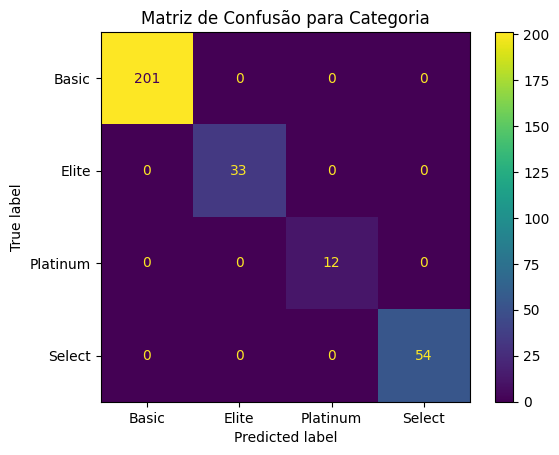

In [112]:
print(f'\nMatriz de Confusão para Categoria')
conf_matrix = confusion_matrix(y_test_c, pred_categoria)
fig = ConfusionMatrixDisplay(conf_matrix,
                                display_labels=['Basic', 'Elite', 'Platinum', 'Select'],
                                )
fig.plot()
plt.title(f'Matriz de Confusão para Categoria')

Vemos que para predizer a categoria e a utlidade do cartão o modelo obteve uma  otima performance.

In [117]:
pred_bandeira_proba = final_model_bandeira.predict_proba(X_test)
log_loss_score_bandeira = log_loss(y_test_b, pred_bandeira_proba)
print(f'Bandeira: {log_loss_score_bandeira:.4f}')

pred_utilidade_proba = final_model_utilidade.predict_proba(X_test)
log_loss_score_utilidade = log_loss(y_test_u, pred_utilidade_proba)
print(f'Utilidade: {log_loss_score_utilidade:.4f}')

pred_categoria_proba = final_model_categoria.predict_proba(X_test)
log_loss_score_categoria = log_loss(y_test_c, pred_categoria_proba)
print(f'Categoria: {log_loss_score_categoria:.4f}')

Bandeira: 1.1944
Utilidade: 0.0497
Categoria: 0.0012


### Predição em Prospects

In [118]:
df_prospect = pd.read_csv(r'.\datasets\dataset_prospect_score.csv')
df_original = df_prospect.copy()

In [120]:
df_prospect.drop(columns=['ID_Prospect', 
                          'Nome',
                          'Tempo na Empresa', 
                          'Possui Carro',
                          'Pessoas em Casa',
                          'Cidade',
                          'Cargo',
                          'Estado Civil',
                          'Moradia'],axis=1,inplace=True)

In [122]:
prospect_pred_bandeira = final_model_bandeira.predict(df_prospect)
prospect_pred_utilidade= final_model_utilidade.predict(df_prospect)
prospect_pred_categoria = final_model_categoria.predict(df_prospect)

In [130]:
prospect_pred_utilidade = prospect_pred_utilidade.ravel()
prospect_pred_categoria = prospect_pred_categoria.ravel()


In [133]:
df_original['Principal Cartão'] = "Rocketseat " + prospect_pred_bandeira.astype(str) + " " + prospect_pred_utilidade.astype(str) + " " + prospect_pred_categoria.astype(str)

In [134]:
df_original

,ID_Prospect,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,...,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão
0,de943fb0-5e23-4e7f-8130-1aa76b33f4dc,Francisco Fonseca,24,1,1,4,5,4,1,5,...,6,Próprio,True,46006,736831,371505,88180,42.219,340,Rocketseat Visa Life Elite
1,5050d0e5-5d35-4cb1-a208-596a3ee4ac1d,Melissa Mendes,58,1,4,5,3,2,3,3,...,2,Próprio,False,38086,374702,1828554,31206,50.168,334,Rocketseat Mastercard Life Elite
2,435005c0-50ea-4755-acef-b4362c08dccd,Lucca Costa,18,2,4,1,1,3,1,3,...,6,Próprio,False,42531,933858,1295274,178144,76.357,158,Rocketseat Mastercard Life Select
3,4e9951b4-1790-484c-ab25-189aa9089241,Francisco da Luz,20,4,3,1,4,1,4,2,...,6,Próprio,True,16112,698799,1574952,434757,88.360,49,Rocketseat Visa Travel Basic
4,cb434840-2bf0-4516-8a79-8c9ada489c03,Sr. Vinícius Costela,22,1,1,4,3,5,2,3,...,3,Próprio,True,3059,920950,449866,224609,67.165,127,Rocketseat Mastercard Shopping Select
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9f6c824b-f107-4cab-a12f-84dd3b2bd1cb,Mateus Siqueira,64,4,2,4,1,2,5,5,...,1,Próprio,False,43468,509704,898442,252781,70.339,131,Rocketseat Visa Shopping Select
496,ffd7325a-fbcb-4f8d-9a3a-e6417b339ceb,Elisa Santos,29,1,1,1,3,2,1,3,...,1,Próprio,True,18628,587861,765846,456844,83.168,48,Rocketseat Mastercard Life Basic
497,051fa9d2-f447-484c-a0b2-c062b224b0cf,Sr. Vinícius Leão,68,1,5,5,3,1,2,2,...,1,Alugado,False,43112,318696,758764,136074,65.880,158,Rocketseat Mastercard Life Select
498,041df498-64ef-4a8c-9587-daf6f942c0c5,Ayla Farias,77,3,4,5,4,2,5,4,...,2,Próprio,False,33670,82048,495614,230262,70.657,85,Rocketseat Mastercard Life Basic


In [135]:
df_original.to_csv(r'.\datasets\dataset_prospect_cartao.csv')